# Para a Lecture 11  
### Modelar e Simular as propriedades da relação force-length-velocity de Thelen 2003  
#### Lembretes:

$V^{M}$ é a velocidade da fibre muscular
$M$ vem de muscular

$L^{M}$ é o comprimento do **músculo**  

$\overline{F}\,^{M}$ é força externa que age no músculo  

No meu código, $FCE$ é o $F^{M}$ e se refere à força muscular ativa  

$ f_{L}$ é a força internano movimento contrátil  
$a \cdot f_{L} = FLNorm $  é  
$\overline{F}\,^{M} = FCENorm$  é   

$F0$ era para a curva Força Comprimento  

Estou tentando implementar as seguintes equações  

$\,\,\,\,\,\,\, V^{M} = \big(0.25+0.75a\big) \, V^{M}_{max} \, \frac{\overline{F}\,^{M} - \, af_{L}}{b}\,\,\,\,\,\,\,\,\,\,\,$  $\,\,\,\,\,\,\,\,\,\,\,(6)$


$b = \begin{cases} af_{L} + \frac{\overline{F}\,^{M}}{A_{f}} ; & \overline{F}\,^{M}\le af_{L} \\ \frac{ \big( 2+\frac{2}{A_{f}} \big) \, \cdot \, \big(af_{L}\,\overline{F}\,^{M}_{len} \, - \,\overline{F}\,^{M}\big)}{\overline{F}\,^{M}_{len} \,\, - \,\, 1 }; & \overline{F}\,^{M}\gt af_{L} \end{cases} $   $\,\,\,\,\,\,\,\,\,\,\,(7)$

A Eq. $(6)$ depende também do parâmetro $b$ da Eq. $(7)$ que depende de se a fibra está encurtando (primeiro caso) ou alongando (segundo caso).

$\overline{F}\,^{M}_{len}$ é a máxima força muscular normalizada atingível quando seu comprimento está aumentando  

$A_{f} \, = \, 0.25$


In [21]:
import numpy as np
import matplotlib.pyplot as plt
import math


%matplotlib inline

  
### Muscle Properties

In [22]:
Lslack = .223
Lce_o = .093 #optmal length
Fmax = 3000
FlenNorm = Fmax

VMmax = 10 # for young 

Af = 0.25 # according to Thelen(2003) paper

a = 1
b = .25*10 ## now will be computed

### Initial Conditions

In [23]:
LceNorm = .087/Lce_o
t0 = 0
tf = 2.99
h = 1e-3

### Initializations

In [24]:
t = np.arange(t0,tf,h)

F = np.empty(t.shape)
Fkpe = np.empty(t.shape)
fiberLength = np.empty(t.shape)
tendonLength = np.empty(t.shape)
Vm = np.empty(t.shape)

### Functions that will be used

In [25]:
def  computeTendonForce(LseeNorm, Lslack, Lce_o):
    '''
    Compute Tendon Force
    
    Inputs:
        LseeNorm - Normalized Tendon  length
        Lslack - slack length of the tendon (non-normalized)
        Lce_o - Optimal length of the fiber
    Output:
        FtendonNorm - Normalized tendon force
    '''
    
    Umax = .04
    if LseeNorm < Lslack/Lce_o: 
        FTendonNorm = 0
    else: 
        FTendonNorm = ((LseeNorm-Lslack/Lce_o)/(Umax*Lslack/Lce_o))**2
        
    return FTendonNorm


In [26]:
def  computeParallelElementForce(LceNorm):
    Umax = 1
    if LceNorm < 1: 
        FkpeNorm = 0
    else: 
        FkpeNorm = ((LceNorm-1)/(Umax))**2 
        
    return FkpeNorm

In [27]:
def computeForceLengthCurve(LceNorm):
    width = .63
    FLNorm = max([0, (1-((LceNorm-1)/width)**2)])
    return FLNorm

In [28]:
def computeContractileElementDerivative(FLNorm, FCENorm, a, b):
     #calculate CE velocity from Hill's equation
    
    if  FCENorm > FLNorm:
        print('Error: cannot do eccentric contractions')
    
    LceNormdot = -b*(FLNorm-FCENorm)/(a+FCENorm) 
    
    return LceNormdot

In [29]:
def computeContractileElementForce(FtendonNorm, FkpeNorm):
    FCENorm = FtendonNorm - FkpeNorm
    return FCENorm

In [30]:
def computeTendonLength(Lm, Lce_o, LceNorm):
    LseeNorm = Lm/Lce_o - LceNorm
    return LseeNorm

In [31]:
def computeParameterb(FLNorm, FCENorm, Af, FlenNorm):
    '''
    Compute Parameter b
        Inputs:
            FLNorm - 
            FCENorm -
            Af -
            FlenNorm - 
        Output:
            b - 
    '''
    afL = FLNorm
    
    if FCENorm <= afL:
        b = afL + FCENorm / Af
    else:
        b = ((2+2/Af) * (afL*FlenNorm - FCENorm)) / (FlenNorm - 1)
            
    return b

In [32]:
def computeMuscleFiberVelocity(FCENorm, FLNorm, VMmax, a, b):
    '''
    Compute Muscle Fiber Velocity
    
    Inputs:
        FCENorm - Normalized force of Contractile Element
        FLNorm - Normalized relation of Force and Length of the contractile element
        VMmax - maximum contraction velocity        
        a - muscle activation    
        b - parameter that depends on the length of muscle fiber
    
    Output:
        Vm - muscle fiber velocity
    '''
    
    afL = FLNorm
    
    Vm = (0.25 + 0.75 * a) * VMmax * ((FCENorm - afL) / b)
    
    return Vm

## Simulation - Parallel

In [33]:
for i in range (len(t)):
    #ramp
    if t[i]<=1:
        Lm = 0.31
    elif t[i]>1 and t[i]<2:
        Lm = .31 - .04*(t[i]-1)
        #print(Lm)
        
    ########################################################   
    LseeNorm = computeTendonLength(Lm, Lce_o, LceNorm)
    
    FTendonNorm = computeTendonForce(LseeNorm, Lslack, Lce_o)
        
    FkpeNorm = computeParallelElementForce(LceNorm)
      
    FLNorm = computeForceLengthCurve(LceNorm)    
    
    FCENorm = computeContractileElementForce(FTendonNorm, FkpeNorm)
    
    #b = computeParameterb(FLNorm, FCENorm, Af, FlenNorm) # Implemented
    
    Vm_aux = computeMuscleFiberVelocity(FCENorm, FLNorm, VMmax, a, b) # Implemented
    
    LceNormdot = computeContractileElementDerivative(FLNorm, FCENorm, a, b)
    
    LceNorm = LceNorm + h*LceNormdot    
    #########################################################################
    
    F[i] = FTendonNorm * Fmax
    fiberLength[i] = LceNorm * Lce_o
    tendonLength[i] = LseeNorm * Lce_o
    Vm[i] = Vm_aux
    


## Plots

The plot of resultant Force on the muscle versus time

Text(0,0.5,'Force [N]')

<Figure size 432x288 with 0 Axes>

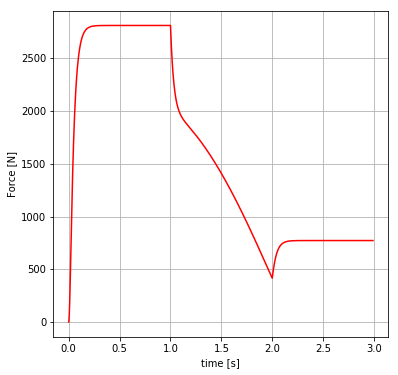

In [34]:
plt.figure()
fig, ax = plt.subplots(1,1, figsize = (6,6),sharex=True)

ax.plot(t,F,c='red')
plt.grid()
plt.xlabel('time [s]')
plt.ylabel('Force [N]')

The plot of Length of the Tendon versus time

Text(0,0.5,'Length [m]')

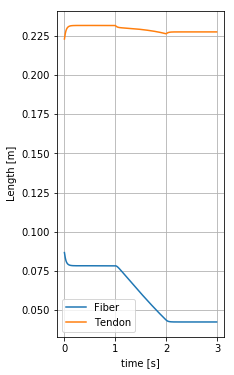

In [35]:
fig, ax = plt.subplots(1,1,figsize=(3,6),sharex=True)

ax.plot(t, fiberLength, label = 'Fiber')
ax.plot(t,tendonLength, label = 'Tendon')
plt.grid()
plt.legend(loc = 'best')
plt.xlabel('time [s]')
plt.ylabel('Length [m]')

The plot of resultant Force on the muscle versus time

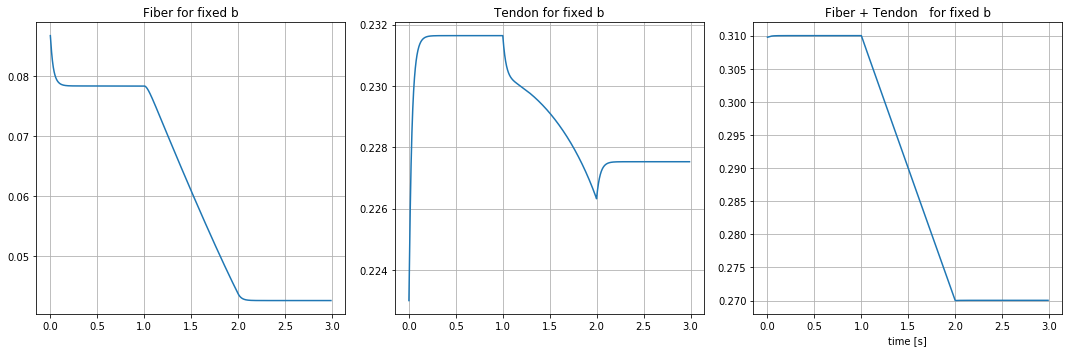

In [36]:
fig, ax = plt.subplots(1, 3, figsize=(15,5), sharex=True)

ax[0].plot(t, fiberLength, label='Fiber')
ax[0].set_title('Fiber for fixed b')
ax[0].grid()
ax[1].plot(t, tendonLength, label='Tendon')
ax[1].set_title('Tendon for fixed b')
ax[1].grid()
plt.xlabel('time [s]')
ax[2].plot(t, fiberLength+tendonLength , label='Fiber+Tendon')
ax[2].set_title('Fiber + Tendon   for fixed b')
ax[2].grid()
plt.tight_layout()

## Now with calculated b and calculating the velocity of muscle

In [37]:
Lslack = .223
Lce_o = .093 #optmal length
Fmax = 3000
FlenNorm = Fmax
LceNorm2 = .087/Lce_o

F2 = np.empty(t.shape)
Fkpe2 = np.empty(t.shape)
fiberLength2 = np.empty(t.shape)
tendonLength2 = np.empty(t.shape)
Vm2 = np.empty(t.shape)
Bs = np.empty(t.shape)

for i in range (len(t)):
    #ramp
    if t[i]<=1:
        Lm = 0.31
    elif t[i]>1 and t[i]<2:
        Lm = .31 - .04*(t[i]-1)
        #print(Lm)
        
    ########################################################   
    LseeNorm2 = computeTendonLength(Lm, Lce_o, LceNorm2)
    
    FTendonNorm2 = computeTendonForce(LseeNorm2, Lslack, Lce_o)
        
    FkpeNorm2 = computeParallelElementForce(LceNorm2)
      
    FLNorm2 = computeForceLengthCurve(LceNorm2)    
    
    FCENorm2 = computeContractileElementForce(FTendonNorm2, FkpeNorm2)
    
    b = computeParameterb(FLNorm2, FCENorm2, Af, FlenNorm) # Implemented
    
    Vm_aux2 = computeMuscleFiberVelocity(FCENorm2, FLNorm2, VMmax, a, b) # Implemented
    
    LceNormdot = computeContractileElementDerivative(FLNorm2, FCENorm2, a, b)
    
    LceNorm2 = LceNorm2 + h*LceNormdot    
    #########################################################################
    
    F2[i] = FTendonNorm2 * Fmax
    fiberLength2[i] = LceNorm2 * Lce_o
    tendonLength2[i] = LseeNorm2 * Lce_o
    Vm2[i] = Vm_aux2
    Bs[i] = b


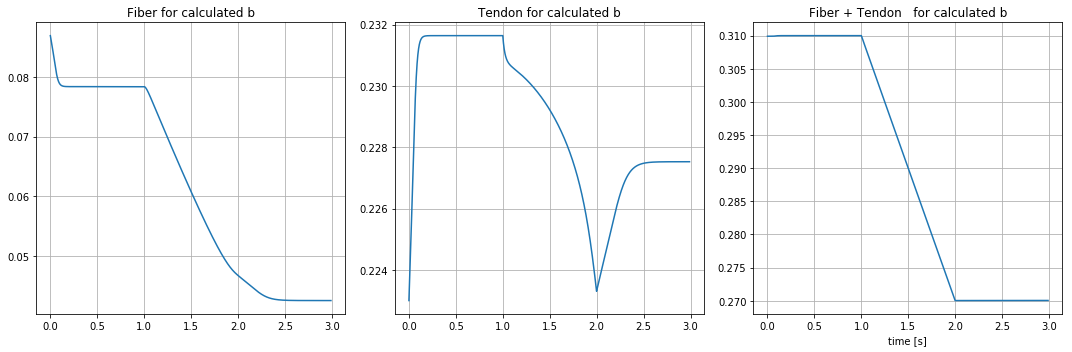

In [38]:
fig, ax = plt.subplots(1, 3, figsize=(15,5), sharex=True)

ax[0].plot(t, fiberLength2, label='Fiber')
ax[0].set_title('Fiber for calculated b')
ax[0].grid()
ax[1].plot(t, tendonLength2, label='Tendon')
ax[1].set_title('Tendon for calculated b')
ax[1].grid()
plt.xlabel('time [s]')
ax[2].plot(t, fiberLength2+tendonLength2 , label='Fiber+Tendon')
ax[2].set_title('Fiber + Tendon   for calculated b')
ax[2].grid()
plt.tight_layout()

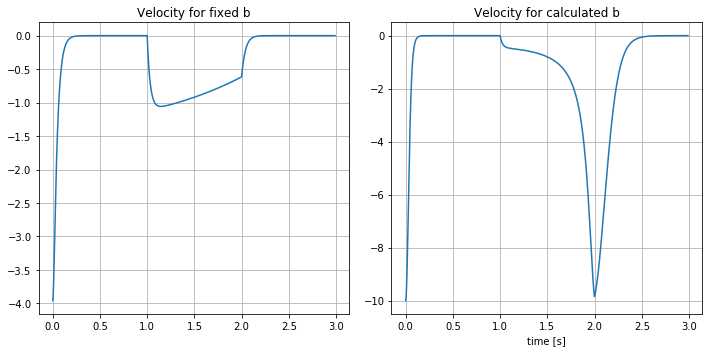

In [39]:
fig, ax = plt.subplots(1, 2, figsize=(10,5), sharex=True)

ax[0].plot(t, Vm, label='Fiber')
ax[0].set_title('Velocity for fixed b')
ax[0].grid()
ax[1].plot(t, Vm2, label='Tendon')
ax[1].set_title('Velocity for calculated b')
ax[1].grid()
plt.xlabel('time [s]')
plt.tight_layout()

Text(0,0.5,'b-values during the simulation')

<Figure size 432x288 with 0 Axes>

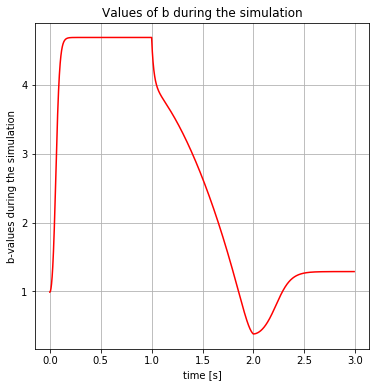

In [40]:
plt.figure()
fig, ax = plt.subplots(1,1, figsize = (6,6),sharex=True)

ax.plot(t,Bs,c='red')
ax.set_title('Values of b during the simulation')
plt.grid()
plt.xlabel('time [s]')
plt.ylabel('b-values during the simulation')

Text(555.295,0.5,'Force [N]')

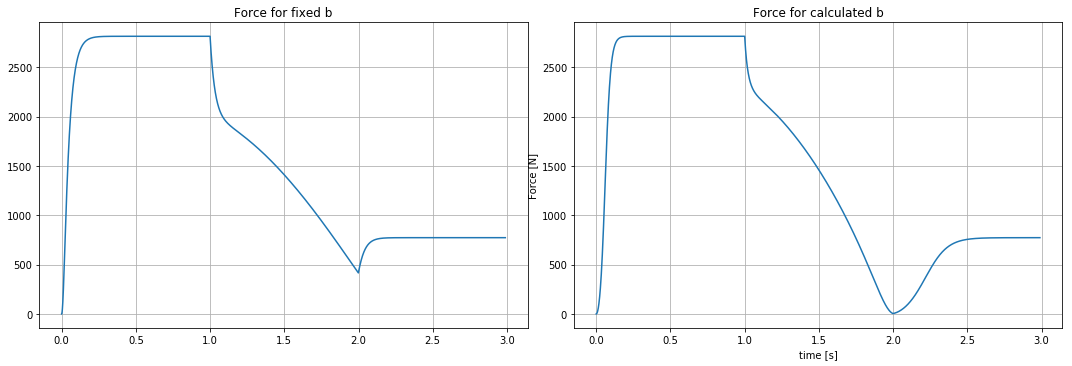

In [43]:
fig, ax = plt.subplots(1, 2, figsize=(15,5), sharex=True)

ax[0].plot(t, F)
ax[0].set_title('Force for fixed b')
ax[0].grid()
ax[1].plot(t, F2)
ax[1].set_title('Force for calculated b')
ax[1].grid()

plt.tight_layout()

plt.xlabel('time [s]')
plt.ylabel('Force [N]')